In [ ]:
!pip install copulas
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t,  beta
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.stats import cauchy
from itertools import combinations
from statsmodels.distributions.empirical_distribution import ECDF
from copulas.multivariate import GaussianMultivariate
from mpl_toolkits.mplot3d import Axes3D
from copulas.bivariate import Clayton
from copulas.multivariate import VineCopula

In [ ]:
end_date = dt.datetime(2025, 3, 1)
start_date = end_date - dt.timedelta(days=365*6)

In [ ]:
tickers =['^NBI','^IXIC','^GSPC','^RUT', 'BTC-USD','^DJI']

In [ ]:
quotes = pd.DataFrame()
for ticker in tickers:
  quotes[ticker] = yf.download(ticker, start_date, end_date)['Close']

quotes = quotes.dropna()
quotes

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,^NBI,^IXIC,^GSPC,^RUT,BTC-USD,^DJI
Date,,,,,,
2019-03-04,3584.100098,7577.569824,2792.810059,1575.439941,3761.557129,25819.650391
2019-03-05,3567.000000,7576.359863,2789.649902,1568.280029,3896.375000,25806.630859
2019-03-06,3454.949951,7505.919922,2771.449951,1536.819946,3903.942627,25673.460938
2019-03-07,3431.729980,7421.459961,2748.929932,1523.630005,3911.484375,25473.230469
2019-03-08,3414.129883,7408.140137,2743.070068,1521.880005,3901.131592,25450.240234
...,...,...,...,...,...,...
2025-02-24,4562.270020,19286.929688,5983.250000,2178.270020,91418.171875,43461.210938
2025-02-25,4532.899902,19026.390625,5955.250000,2170.080078,88736.171875,43621.160156
2025-02-26,4507.930176,19075.259766,5956.060059,2174.169922,84347.023438,43433.121094


In [ ]:
log_return = np.log(quotes/quotes.shift(1)).dropna()

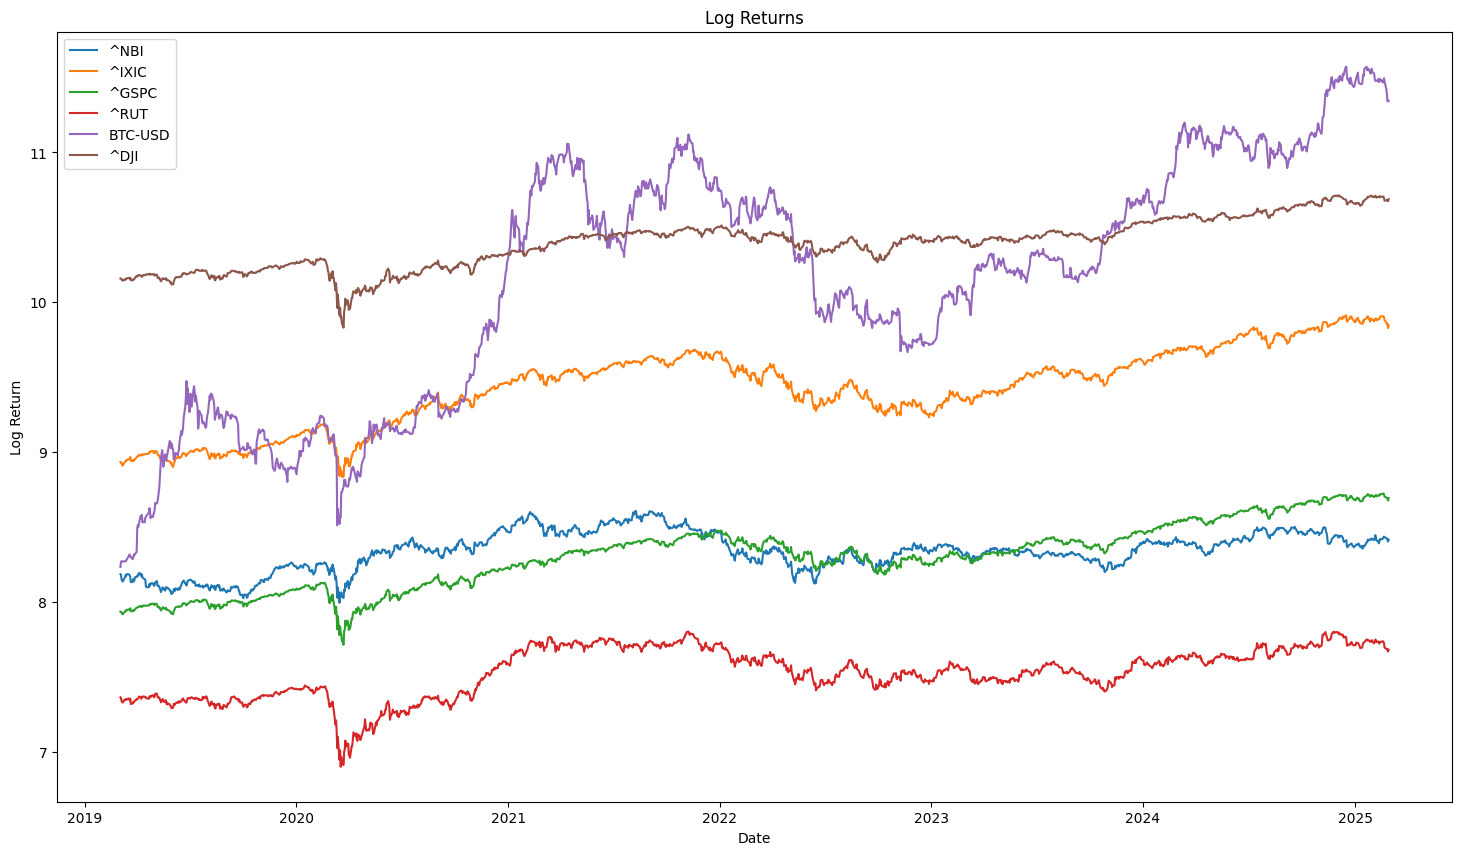

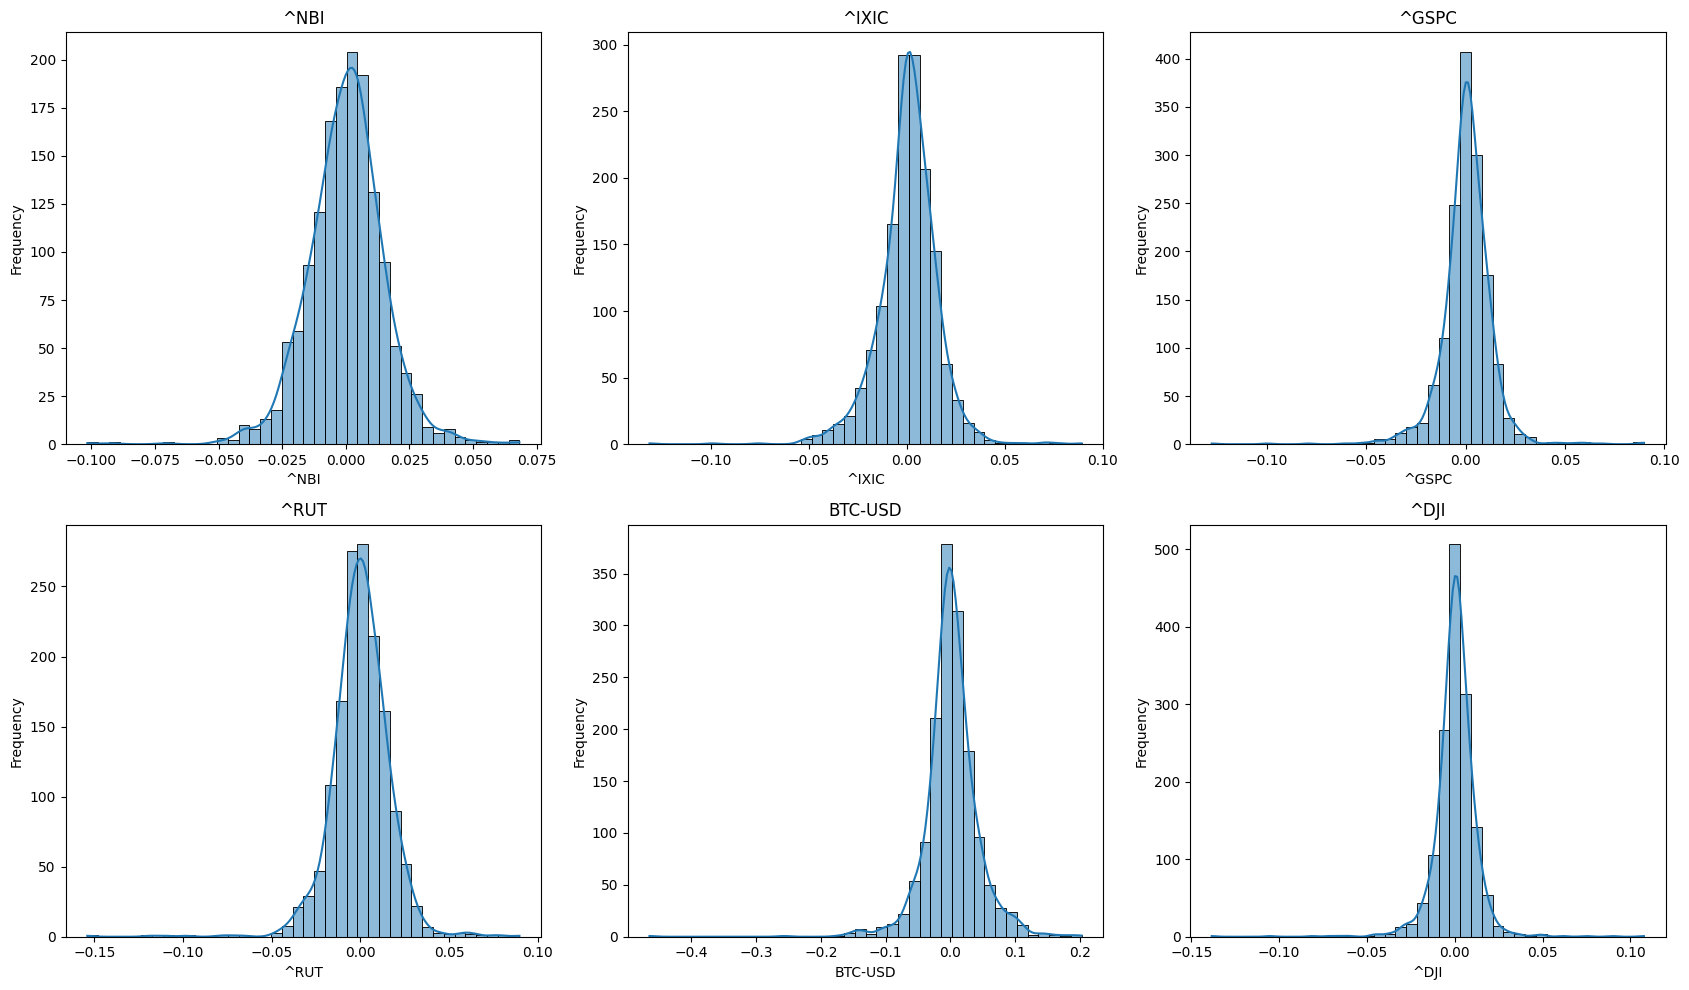

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(np.log(quotes))
plt.title('Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend(tickers)
plt.show()

cols = 3
col = quotes.columns
feature_count = len(col)
rows = (feature_count + cols -1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(17, 5*rows))
axes = axes.flatten()

for i, ax in zip(col, axes):
  sns.histplot(log_return[i], ax=ax, bins=40, kde=True)
  ax.set_title(i)
  ax.set_xlabel(i)
  ax.set_ylabel('Frequency')
for ax in axes[feature_count:]:
  ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
Skewness =  log_return.skew()
Kurtosis = log_return.kurt()
mean = log_return.mean()
std = log_return.std()
pd.DataFrame({'Skewness': Skewness, 'Kurtosis': Kurtosis, 'Mean': mean, 'Standard Deviation': std})


,Skewness,Kurtosis,Mean,Standard Deviation
^NBI,-0.265027,3.429429,0.000154,0.015098
^IXIC,-0.650043,7.336789,0.000605,0.015274
^GSPC,-0.852855,15.294763,0.000502,0.012725
^RUT,-0.896546,10.032583,0.000210,0.016725
BTC-USD,-0.949588,13.452343,0.002064,0.041727
^DJI,-1.018055,23.406636,0.000351,0.012393


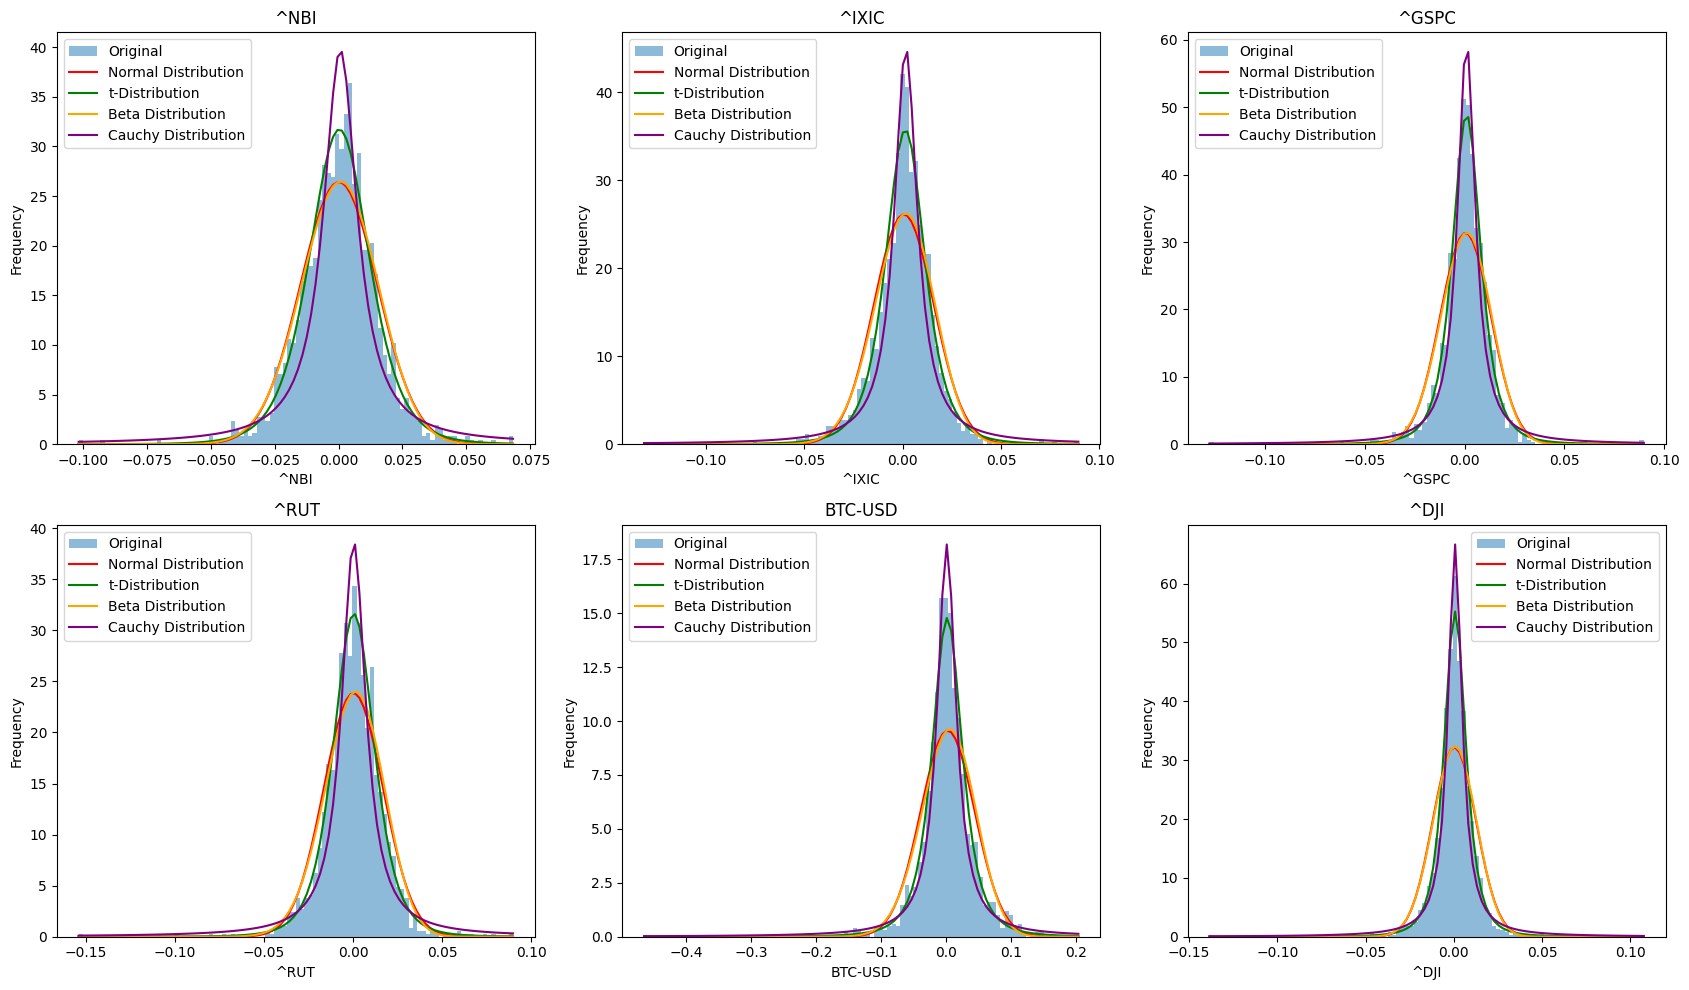

In [ ]:
cols = 3
col = quotes.columns
feature_count = len(col)
rows = (feature_count + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(17, 5 * rows))
axes = axes.flatten()

for i, ax in zip(col, axes):
  #normal
    mean = np.mean(log_return[i])
    std = np.std(log_return[i])

    #T
    params_t = t.fit(log_return[i])
    df, t_loc, t_scale = params_t[0], params_t[1], params_t[2]

  #Beta
    params_beta = beta.fit(log_return[i])
    a, b, loc, scale = params_beta[0], params_beta[1], params_beta[2], params_beta[3]

  #Cauchy
    ca_loc, ca_scale = cauchy.fit(log_return[i])

    x = np.linspace(min(log_return[i]), max(log_return[i]), 100)

    ax.hist(log_return[i], bins=100, density=True, alpha=0.5, label='Original')

    ax.plot(x, norm.pdf(x, mean, std), color='red', label='Normal Distribution')
    ax.plot(x, t.pdf(x, df, t_loc, t_scale), color='green', label='t-Distribution')
    ax.plot(x, beta.pdf(x, a, b, loc, scale), color='orange', label='Beta Distribution')

    ax.plot(x, cauchy.pdf(x, ca_loc, ca_scale), color='purple', label='Cauchy Distribution')

    ax.legend()
    ax.set_title(i)
    ax.set_xlabel(i)
    ax.set_ylabel('Frequency')

for ax in axes[feature_count:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
log_return.corr()

,^NBI,^IXIC,^GSPC,^RUT,BTC-USD,^DJI
^NBI,1.000000,0.734869,0.712184,0.729624,0.267320,0.655842
^IXIC,0.734869,1.000000,0.946661,0.813775,0.348905,0.821435
^GSPC,0.712184,0.946661,1.000000,0.868053,0.329908,0.948451
^RUT,0.729624,0.813775,0.868053,1.000000,0.339990,0.860077
BTC-USD,0.267320,0.348905,0.329908,0.339990,1.000000,0.294617
^DJI,0.655842,0.821435,0.948451,0.860077,0.294617,1.000000


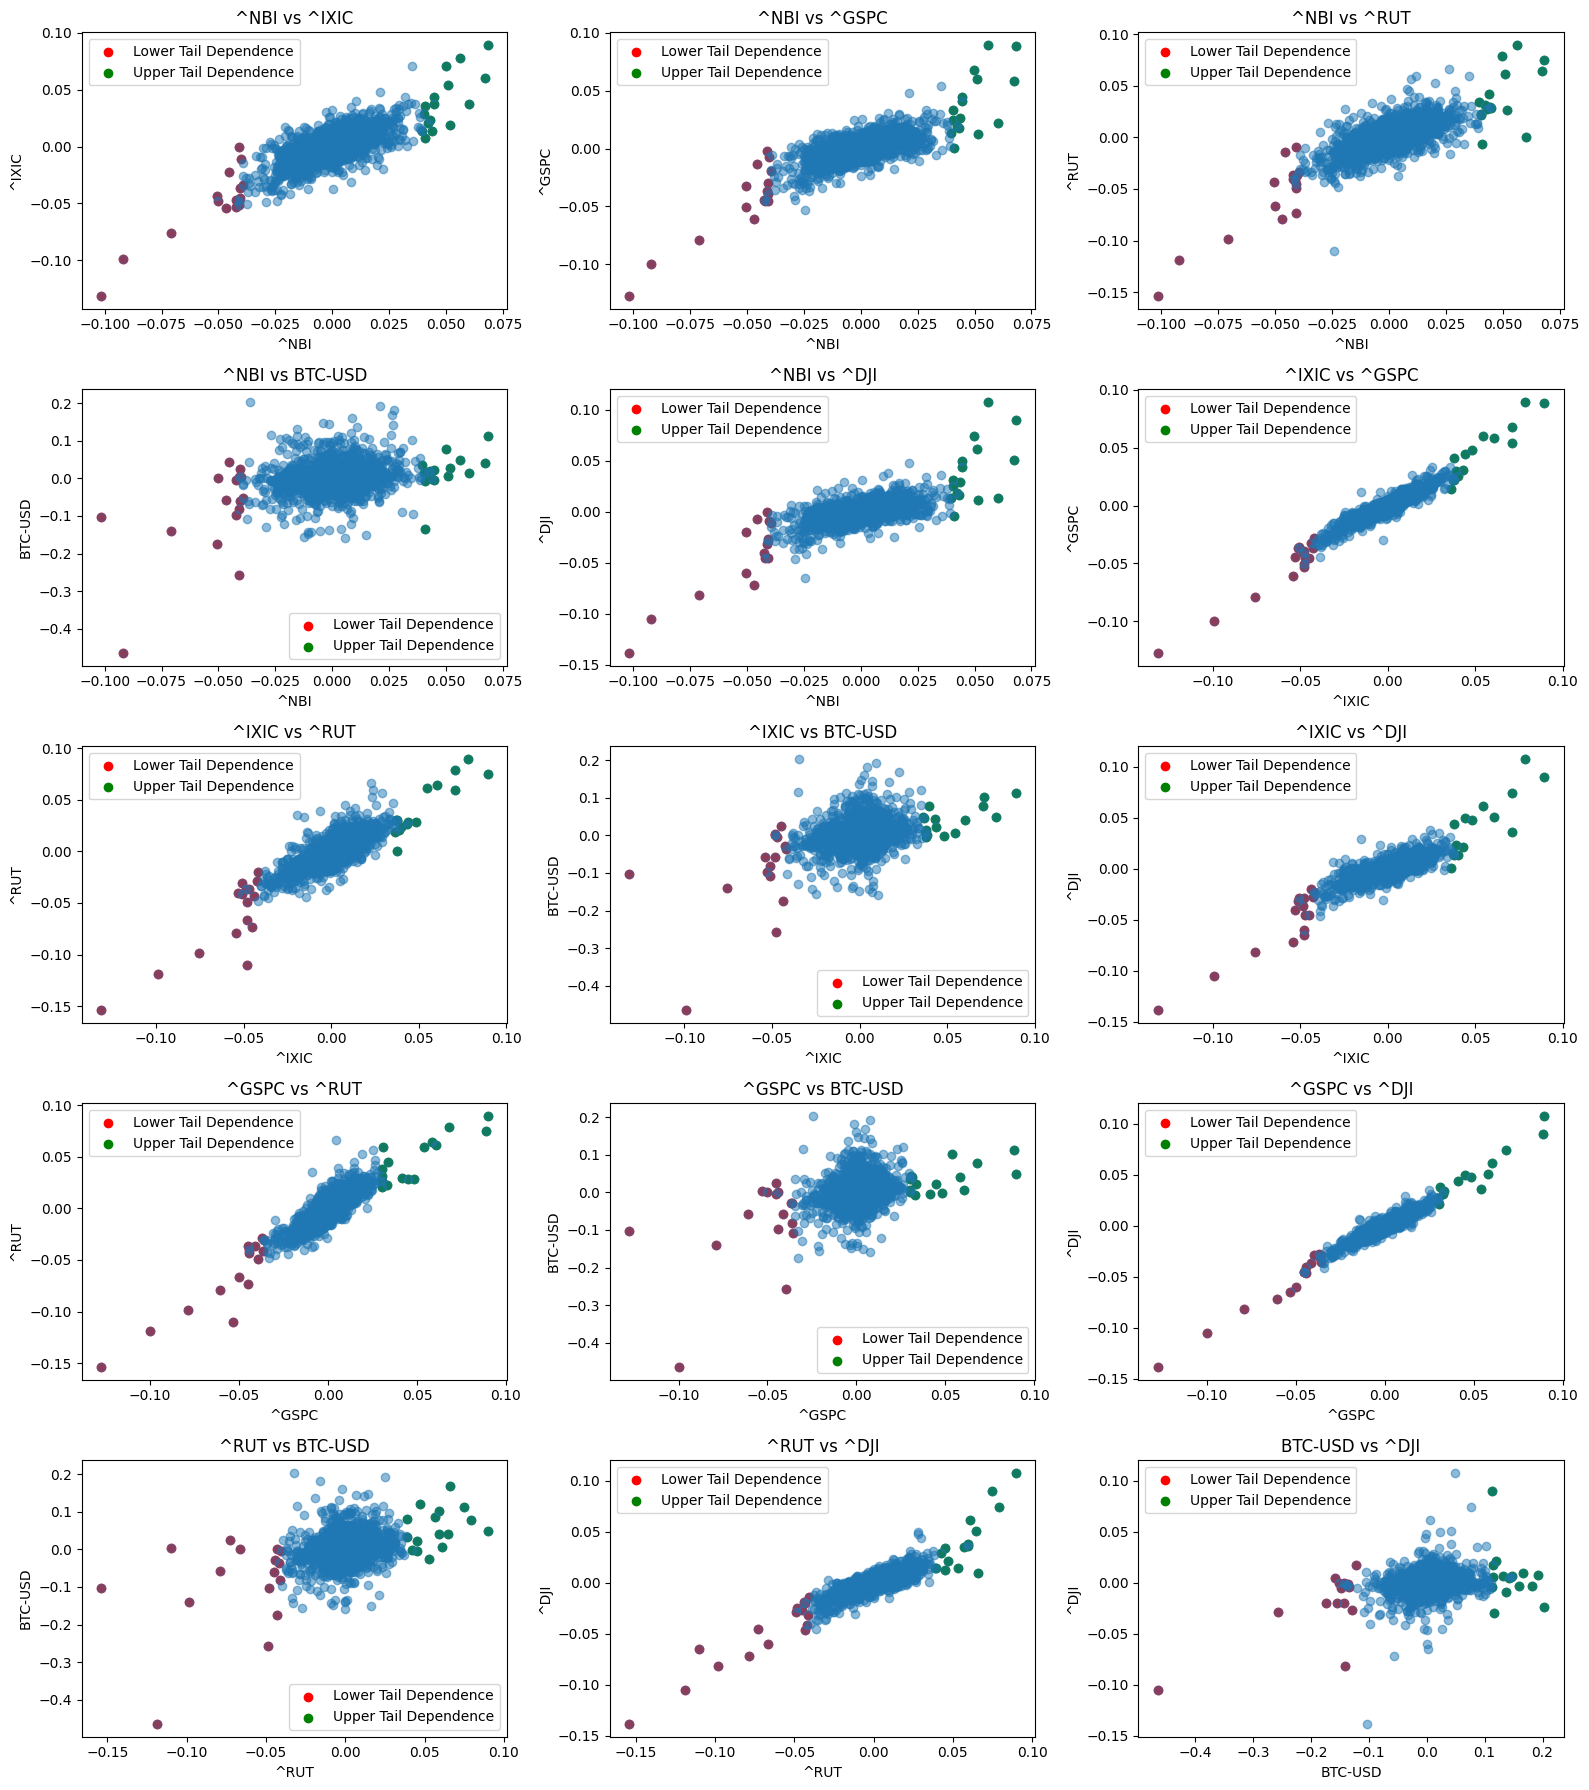

In [ ]:
variables = list(quotes.columns)
pairs = list(combinations(variables,2))
fig, axes = plt.subplots(5, 3, figsize=(16,18))
axes = axes.flatten()

for i, (var1, var2) in enumerate(pairs):

  lower_tail_threshold = np.percentile(log_return[var1], 1)
  lower_extreme_indices = np.where(log_return[var1] <= lower_tail_threshold)
  upper_tail_threshold = np.percentile(log_return[var1], 99)
  upper_extreme_indices = np.where(log_return[var1] >= upper_tail_threshold)

  axes[i].scatter(log_return[var1].iloc[lower_extreme_indices], log_return[var2].iloc[lower_extreme_indices], color='red', label='Lower Tail Dependence')
  axes[i].scatter(log_return[var1].iloc[upper_extreme_indices], log_return[var2].iloc[upper_extreme_indices], color='green', label='Upper Tail Dependence')


  axes[i].scatter(log_return[var1], log_return[var2], alpha=0.5)
  axes[i].set_xlabel(var1)
  axes[i].set_ylabel(var2)
  axes[i].set_title(f'{var1} vs {var2}')
  axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
log_return_cdf = log_return.apply(lambda col:ECDF(col))
transcdf = log_return.apply(lambda col:log_return_cdf[col.name](col))

transcdf

,^NBI,^IXIC,^GSPC,^RUT,BTC-USD,^DJI
Date,,,,,,
2019-03-05,0.345056,0.441274,0.396815,0.348374,0.845388,0.431321
2019-03-06,0.019907,0.199071,0.205707,0.072993,0.511612,0.223623
2019-03-07,0.287989,0.167220,0.157930,0.244194,0.510949,0.149967
2019-03-08,0.337094,0.372926,0.339748,0.453882,0.451891,0.412741
2019-03-11,0.936297,0.933643,0.925680,0.889184,0.501659,0.814864
...,...,...,...,...,...,...
2025-02-24,0.306569,0.151958,0.242867,0.259456,0.069011,0.502322
2025-02-25,0.297943,0.135368,0.250829,0.374917,0.142668,0.665561
2025-02-26,0.324486,0.554745,0.463835,0.548772,0.068348,0.256802


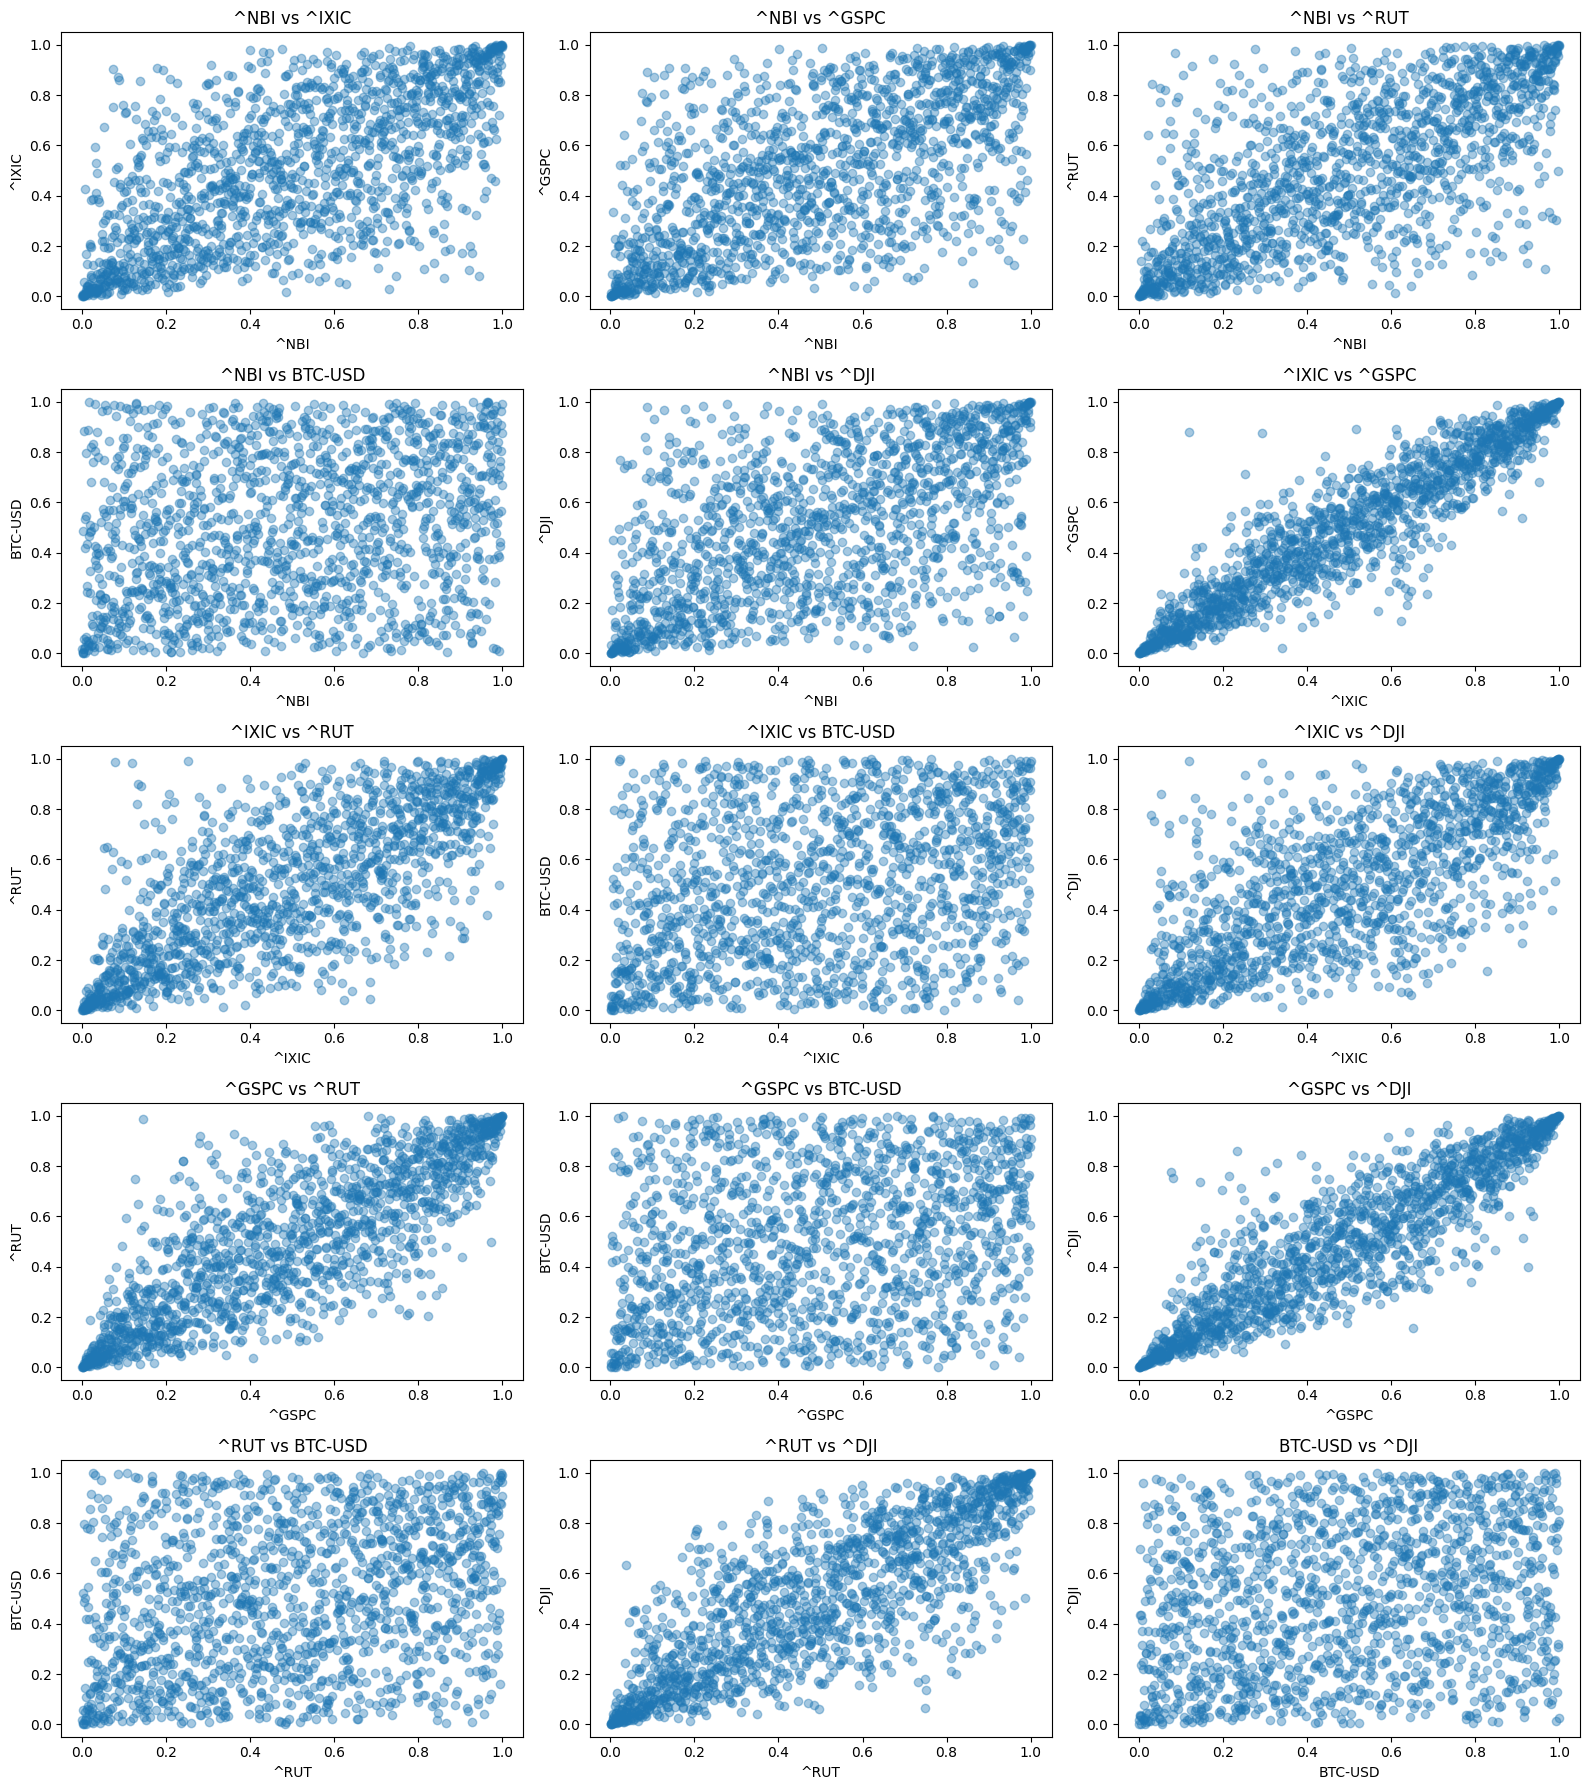

In [ ]:
variabes = list(quotes.columns)
pairs = list(combinations(variabes,2))
fig, axes = plt.subplots(5, 3, figsize=(16,18))
axes = axes.flatten()

for i, (var1, var2) in enumerate(pairs):
  axes[i].scatter(transcdf[var1], transcdf[var2], alpha=0.4)
  axes[i].set_xlabel(var1)
  axes[i].set_ylabel(var2)
  axes[i].set_title(f'{var1} vs {var2}')

plt.tight_layout()
plt.show()